In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%%time
%run ../py/html_analysis.py
hc = HeaderCategories()
ea = ElementAnalysis()
ha = HeaderAnalysis()

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\CHILD_STR_CLF.pickle
Wall time: 46.2 s



----
## Let's use the child strings data to build a NER system

In [3]:

import random

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
feature_dict = random.choice(feature_dict_list)
hc.get_feature_tuple(feature_dict)

('li', "<li>Bachelor's (Preferred)</li>", 'O')


## Train an LDA Model to use as one of the features

In [4]:

file_name, child_strs_list = random.choice(list(ea.CHILD_STRS_LIST_DICT.items()))
navigable_parent = random.choice(child_strs_list)
print(navigable_parent)
ea.lda_predict_percent_is_header(navigable_parent)

<li>Experience with distributed data/computing tools: Map/Reduce, Hadoop, Hive, Spark, Gurobi, MySQL, etc.</li>


0.047620118


## Train an Logistic Regression Model to use as one of the features

In [5]:

print(navigable_parent)
ea.lr_predict_percent_is_header(navigable_parent)

<li>Experience with distributed data/computing tools: Map/Reduce, Hadoop, Hive, Spark, Gurobi, MySQL, etc.</li>


0.08577389794571158


----
## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [6]:

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
sent = [hc.get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]

In [7]:

labels_list = ea.sent2labels(sent)
labels_list

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-JD', 'O', 'H-RQ', 'O', 'H-OL', 'O', 'H-OL', 'O', 'H-IP', 'O', 'O']

In [8]:

features_dict = random.choice(ea.sent2features(sent))
features_dict

{'bias': 1.0, 'tag.document_body_elements_set': True, 'tag.block_elements_set': True, 'tag.basic_text_set': False, 'tag.section_headings_set': False, 'tag.lists_set': True, 'tag.other_block_elements_set': False, 'tag.inline_elements_set': False, 'tag.phrase_elements_set': False, 'tag.presentation_set': False, 'tag.null_element': False, 'postag': 'O', 'child_str.lda': 0.045522094, 'child_str.lr': 0.09028134528890878, '-1:tag.document_body_elements_set': True, '-1:tag.block_elements_set': True, '-1:tag.basic_text_set': False, '-1:tag.section_headings_set': False, '-1:tag.lists_set': True, '-1:tag.other_block_elements_set': False, '-1:tag.inline_elements_set': False, '-1:tag.phrase_elements_set': False, '-1:tag.presentation_set': False, '-1:tag.null_element': False, '-1:postag': 'O', '-1:previous==tag': True, '+1:tag.basic_text_set': False, '+1:tag.block_elements_set': True, '+1:tag.document_body_elements_set': True, '+1:tag.inline_elements_set': False, '+1:tag.lists_set': True, '+1:tag.o

In [9]:

%%time
from sklearn.model_selection import train_test_split

all_sents = []
for file_name, feature_dict_list in HEADER_PATTERN_DICT.items():
    feature_dict_list = [hc.get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]
    all_sents.append(feature_dict_list)
X = [ea.sent2features(s) for s in all_sents]
y = [ea.sent2labels(s) for s in all_sents]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Wall time: 3.61 s


In [10]:

%%time
ea.CRF.fit(X_train, y_train)
s.store_objects(CRF=ea.CRF)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\CRF.pickle
Wall time: 457 ms


## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [11]:

labels = list(ea.CRF.classes_)
labels.remove('O')
labels

['H-TS', 'H-RQ', 'H-SP', 'H-JD', 'H-ER', 'H-PQ', 'H-CS', 'H-OL', 'H-LN', 'H-JT', 'H-PD', 'H-IP', 'H-O']

In [12]:

from sklearn_crfsuite import metrics

y_pred = ea.CRF.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.9154135338345866

In [13]:

print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

              precision    recall  f1-score   support

        H-TS      1.000     1.000     1.000         6
        H-RQ      0.900     1.000     0.947         9
        H-SP      1.000     1.000     1.000         1
        H-JD      1.000     1.000     1.000         4
        H-ER      1.000     1.000     1.000         1
        H-PQ      1.000     1.000     1.000         1
        H-CS      1.000     1.000     1.000         2
        H-OL      1.000     1.000     1.000         5
        H-LN      1.000     0.750     0.857         4
        H-JT      1.000     1.000     1.000         1
        H-PD      0.000     0.000     0.000         0
        H-IP      0.000     0.000     0.000         2
         H-O      0.000     0.000     0.000         0

   micro avg      0.971     0.917     0.943        36
   macro avg      0.762     0.750     0.754        36
weighted avg      0.919     0.917     0.915        36



C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['H-TS', 'H-RQ', 'H-SP', 'H-JD', 'H-ER', 'H-PQ', 'H-CS', 'H-OL', 'H-LN', 'H-JT', 'H-PD', 'H-IP', 'H-O'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [14]:

file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
feature_tuple_list = [hc.get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]
prediction_dict_list = ea.CRF.predict_marginals_single(ea.sent2features(feature_tuple_list))
random.choice(prediction_dict_list)

{'O': 0.9996013865023734, 'H-TS': 2.940639503899148e-05, 'H-RQ': 9.009726632907548e-05, 'H-SP': 2.8007603621326765e-05, 'H-JD': 2.974377481321766e-05, 'H-ER': 6.112892020007765e-05, 'H-PQ': 4.0939180318761586e-05, 'H-CS': 2.1371622471425424e-05, 'H-OL': 2.9684725813953887e-05, 'H-LN': 1.1343257398522543e-05, 'H-JT': 8.512637773068938e-06, 'H-PD': 3.283679976008083e-06, 'H-IP': 1.6557744575588096e-05, 'H-O': 2.8536689296604474e-05}


----
## Make a Prediction Visualization

In [15]:

def plot_child_str_predictions(file_name, ax=None):
    child_strs_list = ha.get_child_strs_from_file(file_name)
    HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
    if file_name in HEADER_PATTERN_DICT:
        feature_dict_list = HEADER_PATTERN_DICT[file_name]
        feature_tuple_list = [hc.get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]
        prediction_dict_list = []
        for prediction_dict in ea.CRF.predict_marginals_single(ea.sent2features(feature_tuple_list)):
            prediction_dict = {'H': 1 - prediction_dict['O']}
            prediction_dict_list.append(prediction_dict)
    else:
        prediction_dict_list = []
        for child_str in child_strs_list:
            if(CLF_NAME == 'LdaModel'):
                H = ea.lda_predict_percent_is_header(child_str)
            else:
                H = ea.lr_predict_percent_is_header(child_str)
            prediction_dict = {'H': H}
            prediction_dict_list.append(prediction_dict)
    rows_list = []
    for child_str, marginals_dict in zip(child_strs_list, prediction_dict_list):
        row_dict = {'probability': marginals_dict['H']}
        if child_str in ha.NAVIGABLE_PARENT_IS_HEADER_DICT:
            row_dict['actual'] = ha.NAVIGABLE_PARENT_IS_HEADER_DICT[child_str] * 1.0
        else:
            row_dict['actual'] = np.nan
        rows_list.append(row_dict)
    df = pd.DataFrame(rows_list)
    coor = round(df.corr().loc['probability', 'actual'], 4)
    if (coor < 0.999) or (ax is not None):
        if ax is None:
            fig = plt.figure(figsize=(18, 2.5))
            ax = fig.add_subplot(1, 1, 1)
            title_text = fig.suptitle(t=f'Correlation to Actual: {coor}', y=1.55)
        AxesSubplot_obj = df.plot.line(ax=ax)
        ax.axis('off')
        for x, child_str in enumerate(child_strs_list):
            y = rows_list[x]['probability']
            if str(y) == 'nan':
                y = rows_list[x]['actual']
            if str(y) != 'nan':
                ax.annotate(f'{child_str[:20]}...', (x, y), ha='left', rotation=90)

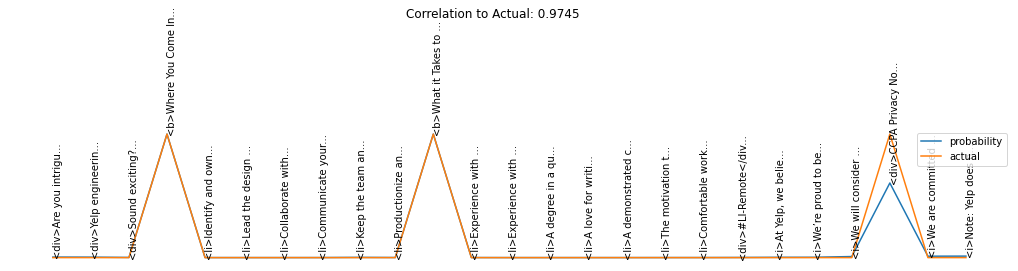

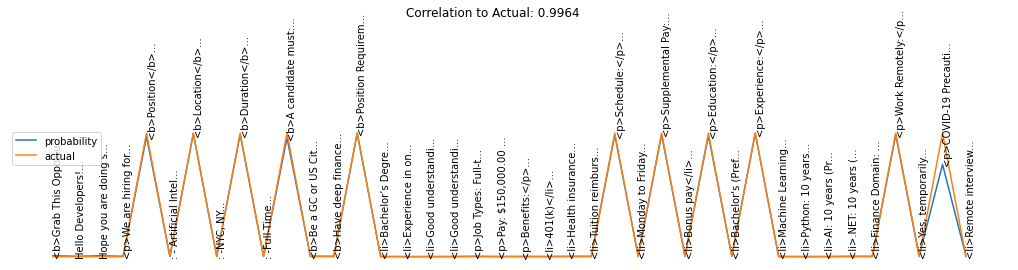

In [16]:

for file_name in list(HEADER_PATTERN_DICT.keys()):
    plot_child_str_predictions(file_name)


----
# Find the Basic Qualifications Section

In [17]:

def find_basic_quals_section(file_name):
    child_strs_list = ha.get_child_strs_from_file(file_name)
    child_tags_list = ha.get_child_tags_list(child_strs_list)
    is_header_list = ha.get_is_header_list(child_strs_list)
    feature_dict_list = hc.get_feature_dict_list(child_tags_list, is_header_list, child_strs_list)
    feature_tuple_list = [hc.get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]
    crf_list = ea.CRF.predict_single(sent2features(feature_tuple_list))
    pos_list = []
    for pos, feature_tuple in zip(crf_list, feature_tuple_list):
        navigable_parent = feature_tuple[1]
        if navigable_parent in ha.NAVIGABLE_PARENT_IS_HEADER_DICT:
            pos_list = hc.append_parts_of_speech_list(navigable_parent, pos_list)
        else:
            pos_list.append(pos)
    consecutives_list = []
    for k, v in groupby(pos_list):
        consecutives_list.append((k, len(list(v))))
    
    return consecutives_list, pos_list, feature_tuple_list, child_strs_list

In [18]:

def find_basic_quals_section(file_name):
    child_strs_list = ha.get_child_strs_from_file(file_name)
    child_tags_list = ha.get_child_tags_list(child_strs_list)
    is_header_list = ha.get_is_header_list(child_strs_list)
    feature_dict_list = hc.get_feature_dict_list(child_tags_list, is_header_list, child_strs_list)
    feature_tuple_list = [hc.get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]
    crf_list = ea.CRF.predict_single(ea.sent2features(feature_tuple_list))
    pos_list = []
    for pos, feature_tuple in zip(crf_list, feature_tuple_list):
        navigable_parent = feature_tuple[1]
        if navigable_parent in ha.NAVIGABLE_PARENT_IS_HEADER_DICT:
            pos_list = hc.append_parts_of_speech_list(navigable_parent, pos_list)
        else:
            pos_list.append(pos)
    consecutives_list = []
    for k, v in groupby(pos_list):
        consecutives_list.append((k, len(list(v))))
    
    return consecutives_list, pos_list, feature_tuple_list, child_strs_list

In [19]:

from itertools import groupby

files_list = os.listdir(ha.SAVES_HTML_FOLDER)
file_name = random.choice(files_list)
while file_name in HEADER_PATTERN_DICT:
    file_name = random.choice(files_list)
consecutives_list, pos_list, feature_tuple_list, child_strs_list = find_basic_quals_section(file_name)
print(consecutives_list)
print(pos_list)
ea.display_basic_requirements(child_strs_list)

[('H-TS', 1), ('O', 3), ('H-JD', 1), ('O', 1), ('H-JD', 1), ('O', 1), ('H-ER', 1), ('O', 1), ('H-CS', 1), ('O', 2), ('H-TS', 1), ('O', 7), ('H-RQ', 1), ('O', 11), ('H-IP', 1), ('O', 12), ('H-SP', 1), ('O', 11), ('H-PQ', 1), ('O', 7), ('H-JD', 1), ('O', 1), ('H-OL', 1), ('O', 1), ('H-CS', 1), ('O', 1), ('H-OL', 1), ('O', 1)]
['H-TS', 'O', 'O', 'O', 'H-JD', 'O', 'H-JD', 'O', 'H-ER', 'O', 'H-CS', 'O', 'O', 'H-TS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-RQ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-IP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-SP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-PQ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-JD', 'O', 'H-OL', 'O', 'H-CS', 'O', 'H-OL', 'O']


In [20]:

for pos_tuple in [(hc.POS_EXPLANATION_DICT[pos],
                   feature_tuple[1] if pos != 'O' else f'{feature_tuple[1][:50]}...') for pos, feature_tuple in zip(pos_list, feature_tuple_list)]:
    print(pos_tuple)

('Task Scope Header', '<h2 class="jobsearch-JobDescriptionSection-jobDescriptionTitle icl-u-xs-my--md" id="jobDescriptionTitle">Full Job Description</h2>')
('Non-header', '<b>Marketing Data Scientist</b>...')
('Non-header', '<b>Reports To:</b>...')
('Non-header', 'SVP, Marketing...')
('Job Duration Header', '<b>Job Location:</b>')
('Non-header', 'Ewing, NJ / Remote...')
('Job Duration Header', '<b>Desired Start Date</b>')
('Non-header', ': Immediate...')
('Education Requirements Header', '<b>Compensation</b>')
('Non-header', ': $60-100K depending on experience...')
('Corporate Scope Header', '<b>Overview:</b>')
('Non-header', 'Is this a place you’d like to work? We’re a team o...')
('Non-header', '<p>Princeton Mortgage seeks to hire a Data Scienti...')
('Task Scope Header', '<b>Responsibilities:</b>')
('Non-header', '<li>Work with stakeholders throughout the organiza...')
('Non-header', '<li>Mine and analyze data from company databases t...')
('Non-header', '<li>Assess the effectivenes

In [ ]:

text_editor_path = r'C:\Program Files\Notepad++\notepad++.exe'
file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
!"{text_editor_path}" "{os.path.abspath(file_path)}"

In [24]:

rows_list = [{'navigable_parent': navigable_parent, 'is_header': is_header} for navigable_parent, is_header in ha.NAVIGABLE_PARENT_IS_HEADER_DICT.items()]
child_str_df = pd.DataFrame(rows_list)
s.store_objects(child_str_df=child_str_df)
child_str_df = s.load_object('child_str_df')
child_str_df[child_str_df.is_header].navigable_parent.tolist()

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\child_str_df.pickle


['<b>Where You Come In:</b>', '<b>What it Takes to Succeed:</b>', '<div>CCPA Privacy Notice</div>', '<b>Position</b>', '<b>Location</b>', '<b>Duration</b>', '<b>A candidate must:</b>', '<b>Position Requirements:</b>', '<p>Schedule:</p>', '<p>Supplemental Pay:</p>', '<p>Education:</p>', '<p>Experience:</p>', '<p>Work Remotely:</p>', '<p>COVID-19 Precaution(s):</p>', '<p>Work Location:</p>', '<b>Responsibilities:</b>', '<b>Qualifications:</b>', '<b>Primary Responsibilities:</b>', '<b>Required Qualifications:</b>', '<b>Preferred Qualifications:</b>', '<b>Careers with Optum.</b>', '<h2 class="jobsearch-JobDescriptionSection-jobDescriptionTitle icl-u-xs-my--md" id="jobDescriptionTitle">Full Job Description</h2>', '<b>What will you do?</b>', '<b>What does your success look like in the first 90 days?</b>', '<b>What are we looking for?</b>', '<b>What skills, experiences, and education are required?</b>', '<b>Why LPL?</b>', '<b>Information on Interviews:</b>', '<b>Location and Travel:</b>', '<b


----

In [25]:

from pycrfsuite import ItemSequence

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
#sequence_obj_dict = {file_name: ItemSequence(feature_dict_list) for file_name, feature_dict_list in HEADER_PATTERN_DICT.items()}
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
sequence_obj = ItemSequence(feature_dict_list)
random.choice(sequence_obj.items())

{'initial_tag:li': 1.0, 'is_header': 0.0, 'is_task_scope': 0.0, 'is_req_quals': 0.0, 'is_preff_quals': 0.0, 'is_legal_notifs': 0.0, 'is_job_title': 0.0, 'is_office_loc': 0.0, 'is_job_duration': 0.0, 'is_supp_pay': 0.0, 'is_educ_reqs': 0.0, 'is_interv_proc': 0.0, 'is_corp_scope': 0.0, 'is_post_date': 0.0, 'is_other': 0.0, 'child_str:<li>Experience with data analysis/statistical software and packages (pandas/statsmodels/sklearn within Python, R, etc.)</li>': 1.0}


----
# Create the Header Pattern Dictionary

In [26]:

files_list = os.listdir(ha.SAVES_HTML_FOLDER)
HEADER_PATTERN_DICT = {}
for file_name in files_list:
    if file_name in ea.CHILD_STRS_LIST_DICT:
        child_strs_list = ea.CHILD_STRS_LIST_DICT[file_name]
    else:
        file_path = os.path.join(ha.SAVES_HTML_FOLDER, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            html_str = f.read()
            body_soup = ha.get_body_soup(html_str)
            child_strs_list = ha.get_navigable_children(body_soup, [])
    navigable_parent = child_strs_list[0]
    if navigable_parent not in ha.NAVIGABLE_PARENT_IS_HEADER_DICT:
        continue
    child_tags_list = []
    is_header_list = []
    for navigable_parent in child_strs_list:
        if navigable_parent not in ha.NAVIGABLE_PARENT_IS_HEADER_DICT:
            break
        tokenized_sent = ha.html_regex_tokenizer(navigable_parent)
        try:
            first_token = tokenized_sent[0]
            if first_token[0] == '<':
                child_tags_list.append(first_token[1:])
            else:
                child_tags_list.append('plaintext')
        except:
            child_tags_list.append('plaintext')
        is_header = ha.NAVIGABLE_PARENT_IS_HEADER_DICT[navigable_parent]
        is_header_list.append(is_header)
    if len(child_tags_list) == len(child_strs_list):
        if file_name not in ea.CHILD_STRS_LIST_DICT:
            ea.CHILD_STRS_LIST_DICT[file_name] = child_strs_list
            s.store_objects(CHILD_STRS_LIST_DICT=ea.CHILD_STRS_LIST_DICT)
        if file_name not in HEADER_PATTERN_DICT:
            item_sequence = hc.get_feature_dict_list(child_tags_list, is_header_list, child_strs_list)
            HEADER_PATTERN_DICT[file_name] = item_sequence
            s.store_objects(HEADER_PATTERN_DICT=HEADER_PATTERN_DICT)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle


In [ ]:

import sys

command_str = f'{sys.executable} -m pip install --upgrade sklearn-crfsuite'
print(command_str)
!{command_str}